<a href="https://colab.research.google.com/github/NishitSingh2023/NLP_PROJECT_LIDO/blob/master/NLP_on_Demo_Teacher_Reviews_1_14_Sept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re           
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from bs4 import BeautifulSoup 

In [ ]:
!pip install pyLDAvis
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


import warnings
warnings.filterwarnings("ignore")
import io
from google.colab import files 

# The DataSet taken Is from MetaBase Link :- 
https://metabase.lidolearning.com/question/2677?start_date=2020-10-01&end_date=2020-10-03

In [ ]:
# upload JUST the csv here
uploaded = files.upload()
## Change CSV name here 
data = pd.read_csv(io.BytesIO(uploaded['reviews(1-14).csv']))

Saving reviews(1-14).csv to reviews(1-14).csv


In [ ]:
data.head()

,product_feedback,product_rating,teacher_id,teacher_name,teacher_rmn,vc_id,start_time,count_students,student_ids,student_names,student_rmns
0,1. Most of the times the screen share option c...,1.0,28e89e38-fb05-4082-84aa-1f9443d43383,Lalit Upadhyay,9004097187,4fc2f040-aaef-4e2e-9c9d-101d3f5b7bc6,2020-09-05T16:00:00+05:30,3,"{76dd93d7-0336-4e49-b3bd-1fe92e6ca289,9af94c6c...","{Sachi,SAKSHAM,Tanesh}","{8018256529,8126414600,9027917598}"
1,aaditya tried everything but his mic did not w...,1.0,f09c9aef-c221-4858-b0b6-cfee341fa761,Vasundhara Guleria,8264861796,0c964071-5fc0-42a0-a6a9-d42cc59e0f61,2020-09-12T13:00:00+05:30,4,"{2543fa86-1748-4b31-a8ca-7040943f791e,5b471717...","{ADITYA,AWADH,KAVERI,""Zara Khan ""}","{8387977000,9399073915,9587358465,9878138080}"
2,activities are not visible\n,1.0,06611ce3-2636-4060-8fe6-beff2a09a7c0,Meenakshi Nagpal,7988189284,41266605-d286-421f-be95-ed0423ba1d1d,2020-09-05T11:00:00+05:30,3,"{191a5fc4-debe-4108-adab-18e8bfe2ddcc,329d4597...","{HARSHPREET,""Palak goel "",SINCHANA}","{6239228140,9311489275,9740879988}"
3,"Anurag is having least intrest in this class, ...",1.0,d73677b0-7f22-4028-8a76-1dcec5347ab4,Nirmal Kumar Singh,8982753944,cfc68463-3c65-4a9f-80fa-d0ad52ba136f,2020-09-09T18:00:00+05:30,3,"{5200eb31-49ec-4a2c-9170-4660d25e931b,523bf469...","{""Anurag "",""Ayan Ansari"",Karthik}","{7275767144,8979812304,9133095437}"
4,At end of the class. I and aliza both face som...,1.0,55aebf7f-6a90-491e-931d-3e0e0666dca8,Riya Makhani,6353905546,61c64a19-4c80-4fd3-a67f-58e69037c1fb,2020-09-02T16:00:00+05:30,1,{5407c90c-ab9c-4228-b2a0-071d8e3d496f},{ALIZAA},{7417134771}


In [ ]:
data.shape

(3311, 11)

In [ ]:
data.dtypes

product_feedback     object
product_rating      float64
teacher_id           object
teacher_name         object
teacher_rmn           int64
vc_id                object
start_time           object
count_students        int64
student_ids          object
student_names        object
student_rmns         object
dtype: object

In [ ]:
data.isnull().sum()

product_feedback    2144
product_rating       869
teacher_id             0
teacher_name           0
teacher_rmn            0
vc_id                  0
start_time             0
count_students         0
student_ids            0
student_names          0
student_rmns           0
dtype: int64

In [ ]:
data.describe

<bound method NDFrame.describe of                                        product_feedback  ...                                   student_rmns
0     1. Most of the times the screen share option c...  ...             {8018256529,8126414600,9027917598}
1     aaditya tried everything but his mic did not w...  ...  {8387977000,9399073915,9587358465,9878138080}
2                         activities are  not visible\n  ...             {6239228140,9311489275,9740879988}
3     Anurag is having least intrest in this class, ...  ...             {7275767144,8979812304,9133095437}
4     At end of the class. I and aliza both face som...  ...                                   {7417134771}
...                                                 ...  ...                                            ...
3306                                                NaN  ...  {7993344999,9840201854,9872084244,9958714145}
3307                                                NaN  ...                        {7488079956,987342

### Total Rating including Null Values 

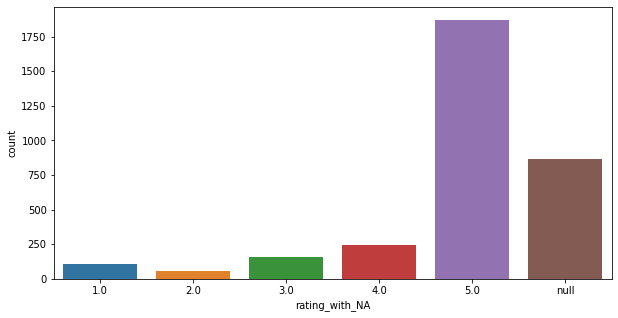

In [ ]:
plt.figure(figsize=(10,5))
data["rating_with_NA"] = data['product_rating'].fillna('null')
sns.countplot(data['rating_with_NA'])

### Total Reviews including Null Values 

Text(0.5, 0, 'Null Reviews')

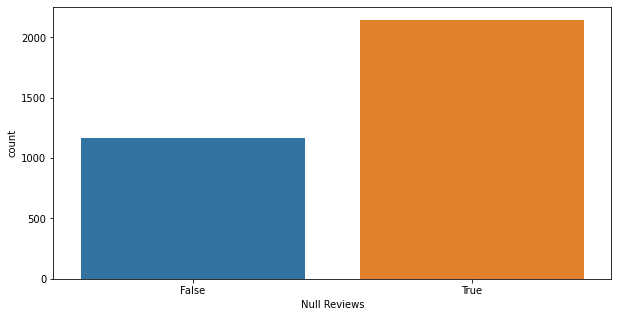

In [ ]:
plt.figure(figsize=(10,5))
ax =sns.countplot(data['product_feedback'].isnull())
ax.set_xlabel(xlabel="Null Reviews")

In [ ]:
data = data.dropna(subset=['product_feedback'])

## WordCloud

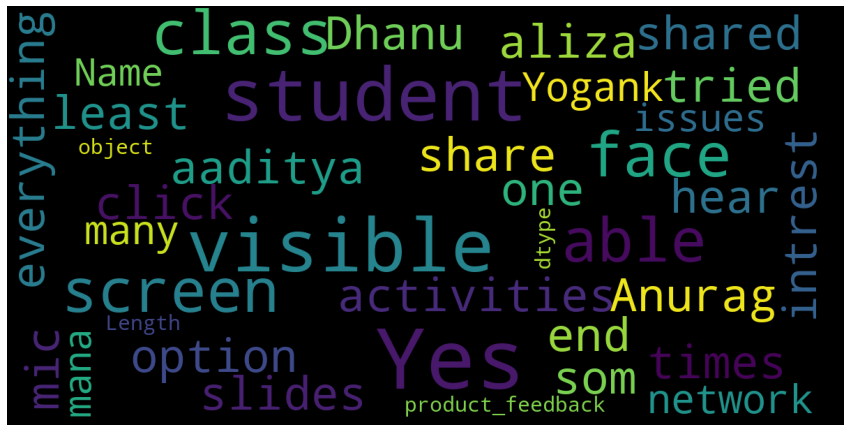

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(data['product_feedback'])

### Reviews_length and Number of reviews respect to Product_rating

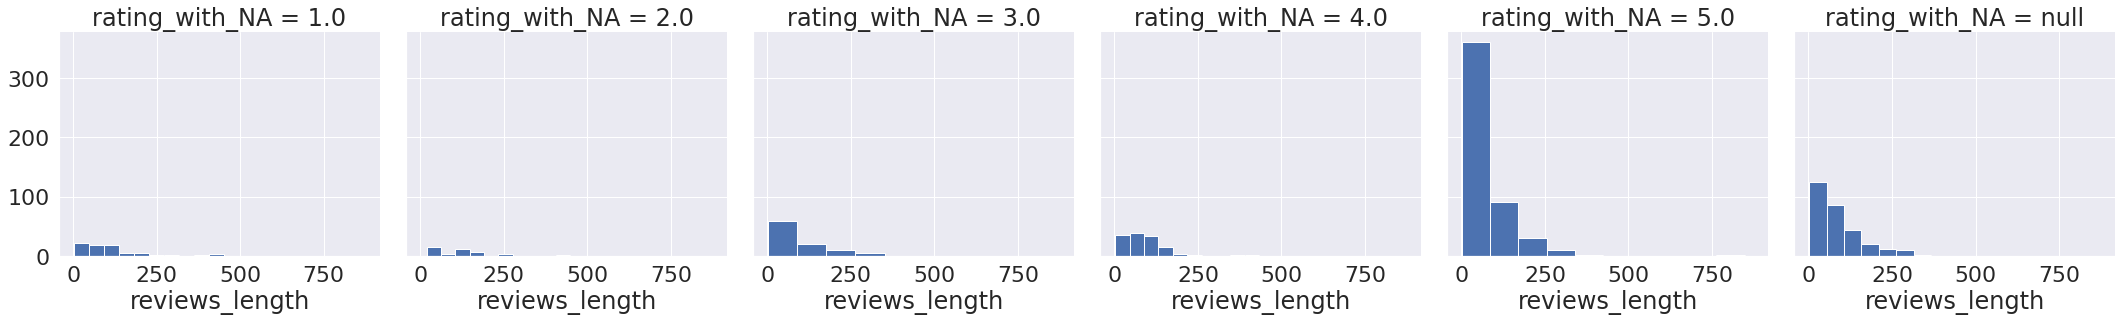

In [ ]:
data['reviews_length']=data['product_feedback'].apply(len)
sns.set(font_scale=2.0)

g = sns.FacetGrid(data,col='rating_with_NA',size=5)
g.map(plt.hist,'reviews_length')

## Correlation Plot

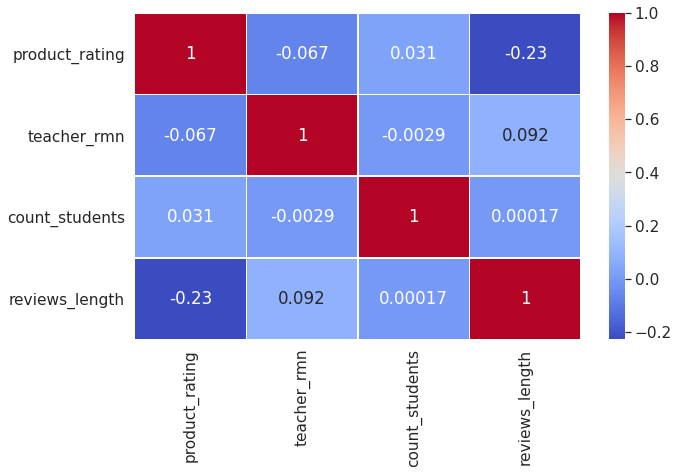

In [ ]:
sns.set(font_scale=1.4)
plt.figure(figsize = (10,6))
sns.heatmap(data.corr(),cmap='coolwarm',annot=True,linewidths=.5)

In [ ]:
all_text = data['product_feedback']
for i in range(min(10, len(all_text))):
    print(all_text[i])
    print("#========================================#")

1. Most of the times the screen share option creates technical issues and ruins the class. (Even when network is good).
2. Student (Saksham, Grade 7, Maths) had some issue after I tried sharing screen, he turned offline and was not able to re-login.
3. Game website on slide number 10 - (https://in.mathgames.com/skill/7.8-multiply-fractions) always takes a lot of time in opening.
#========================================#
aaditya tried everything but his mic did not work, kaveri was not near the screen but could hear her talking in the background  
#========================================#
activities are  not visible

#========================================#
Anurag is having least intrest in this class, but he is more focus on class book problem. I solve some .
Kartik join late but great student , weak in some sort of calculation.
#========================================#
At end of the class. I and aliza both face some networking issues. But I managed it and try to complete the clas

### Reviews_length and Number of reviews respect to product_rating and Count students in class

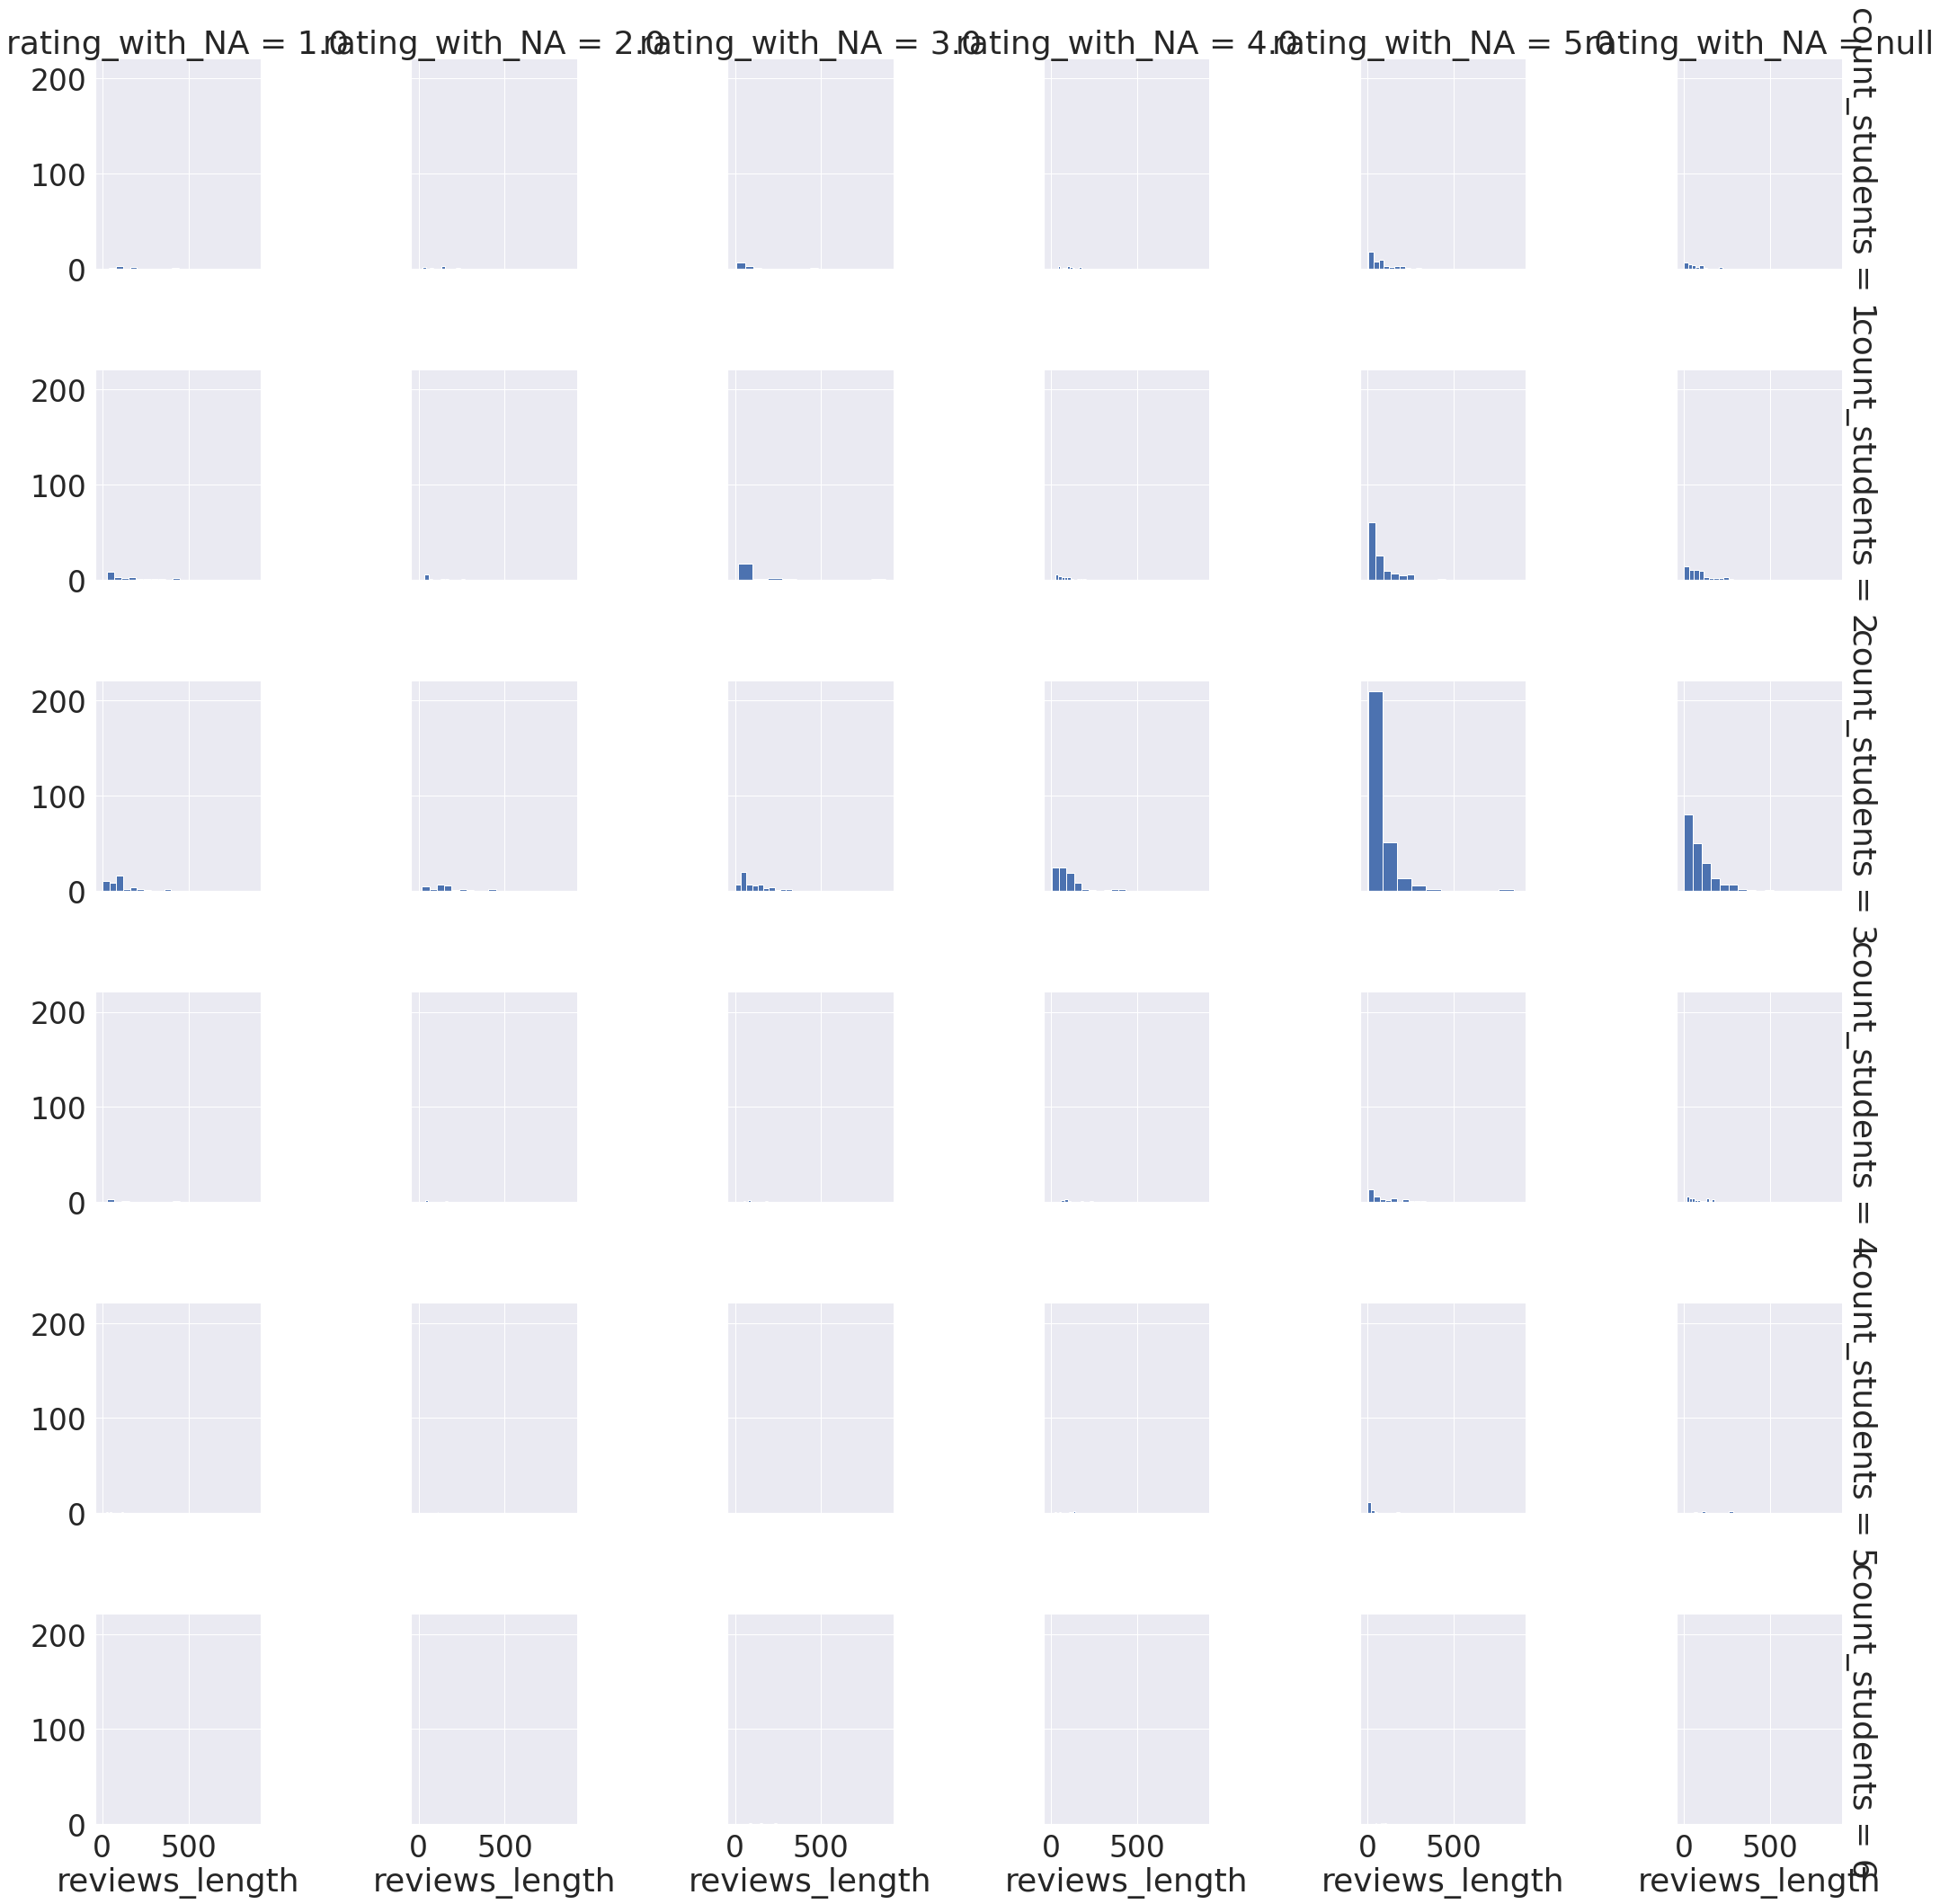

In [ ]:
sns.set(font_scale=3.0)

g = sns.FacetGrid(data,col='rating_with_NA', row= 'count_students',size=5, margin_titles=True)
g.map(plt.hist,'reviews_length')

## Text Cleaning

In [ ]:
##### Text Cleaning ######

#No of words in reviews
data['number_of_words'] = data.product_feedback.apply(lambda x: len(x.split()))

# Remove Cleaned Feedback
index_names = data[ data['number_of_words'] <= 4  ].index
data.drop(index_names, inplace = True) 

# Lower
data['cleaned_feedback'] = data['product_feedback'].str.lower() 

# Remove URLs
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

data['cleaned_feedback'] = data['cleaned_feedback'].apply(lambda text: remove_urls(text))

# Remove Punctuation
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

data['cleaned_feedback'] = data['cleaned_feedback'].apply(lambda text: remove_punctuation(text))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
data.shape

(853, 15)

## Word Net Lemmatizer

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

data['cleaned_feedback'] = data['cleaned_feedback'].apply(lambda text: lemmatize_words(text))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


## Correcting Spelling Mistakes

In [ ]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 2.8MB/s 


In [ ]:
# NOTE: WILL TAKE SOME TIME TO COMPLETE (SLOW PROCESS 5-10min)
# A good Idea would be to export the DATA to CSV to Avoid this step Again and again

from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
data['cleaned_feedback'] = data['cleaned_feedback'].apply(lambda text: correct_spellings(text))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
data['cleaned_feedback']

0       1 most of the time the screen share option cre...
1       aaditya try everything but his mic do not work...
3       aura be have least interest in this class but ...
4       at end of the class i and liza both face some ...
5       at first my mic be not work so i ask to reload...
                              ...                        
2744    yes the screen that be share be not visible to...
2745             yes the slide be not visible for student
2746    yes the student dhani be not able to hear me e...
2747    yes the student be not able to click one of th...
2748    logan face so many network issue but i manage ...
Name: cleaned_feedback, Length: 853, dtype: object

## Sentiment Analysis

In [ ]:
pip install watson_developer_cloud

     |████████████████████████████████| 256kB 2.8MB/s 
     |████████████████████████████████| 204kB 42.7MB/s 
  Created wheel for watson-developer-cloud: filename=watson_developer_cloud-2.10.1-cp36-none-any.whl size=252814 sha256=ed308ad954f59e4a59c883d3c90d1f30bf24ce67f55071ccf102ba6aff8e87ca
  Stored in directory: /root/.cache/pip/wheels/ea/a7/19/fac0a408a586265eb374005308a7553d4494ab41b2fd88f5bc
Successfully built watson-developer-cloud


In [ ]:
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions, SentimentOptions, CategoriesOptions

In [ ]:
natural_language_understanding = NaturalLanguageUnderstandingV1(                                         
    version='2020-08-01',
    iam_apikey='bXSAw6fRZRB4OJCfBNQgnGdH-h3KrkNs-bftWJwrbx73', # Use your API key here
    url='https://api.kr-seo.natural-language-understanding.watson.cloud.ibm.com/instances/0fcf4d52-23ce-47cc-ba82-d9f47e3735fe'
    )
def Sentiment_score(input_text): 
    # Input text can be sentence, paragraph or document
    response = natural_language_understanding.analyze (
    text = input_text,
    features = Features(sentiment=SentimentOptions()), language='en').get_result()
    # From the response extract score which is between -1 to 1
    res = response.get('sentiment').get('document').get('score')
    return res

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: watson-developer-cloud moved to ibm-watson. To get updates, use the new package.
  after removing the cwd from sys.path.


#### Note: NLU are limited to 30,000 per month please **avoid running multiple times**

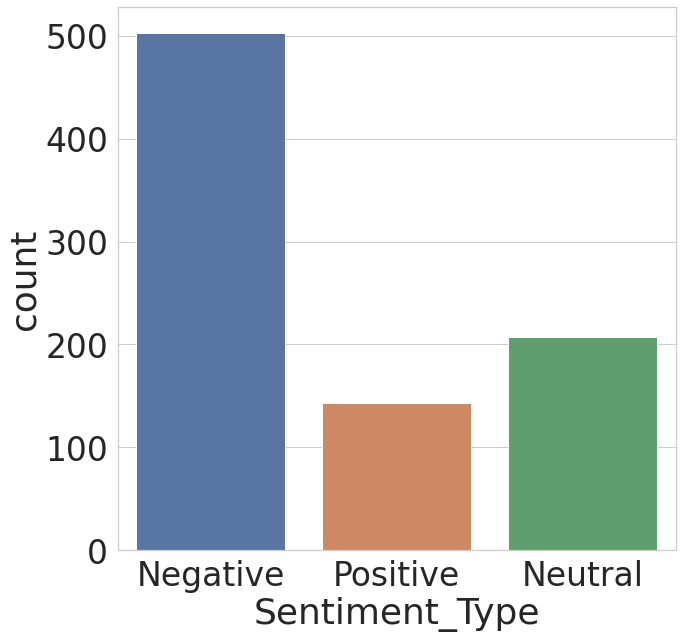

In [ ]:
# NOTE: WILL TAKE SOME TIME TO COMPLETE (SLOW PROCESS 5-10min)

list_desc = list()

df = data['cleaned_feedback'].astype(str)

def f(df):
    if df['sentiment'] > 0:
        val = "Positive"
    elif df['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

for row in df:
    list_desc.append((row, Sentiment_score(row)))
    df = pd.DataFrame(list_desc, columns = ['sentence','sentiment'])
    

df['Sentiment_Type'] = df.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df)

In [ ]:
df

,sentence,sentiment,Sentiment_Type
0,1 most of the time the screen share option cre...,-0.882468,Negative
1,aaditya try everything but his mic do not work...,-0.810417,Negative
2,aura be have least interest in this class but ...,-0.541781,Negative
3,at end of the class i and liza both face some ...,0.996917,Positive
4,at first my mic be not work so i ask to reload...,-0.969891,Negative
...,...,...,...
848,yes the screen that be share be not visible to...,0.681424,Positive
849,yes the slide be not visible for student,0.000000,Neutral
850,yes the student dhani be not able to hear me e...,-0.896833,Negative
851,yes the student be not able to click one of th...,-0.753344,Negative


In [ ]:
data.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

data = pd.concat( [data, df], axis=1) 

In [ ]:
data.head()

,product_feedback,product_rating,teacher_id,teacher_name,teacher_rmn,vc_id,start_time,count_students,student_ids,student_names,student_rmns,rating_with_NA,reviews_length,number_of_words,cleaned_feedback,sentence,sentiment,Sentiment_Type
0,1. Most of the times the screen share option c...,1.0,28e89e38-fb05-4082-84aa-1f9443d43383,Lalit Upadhyay,9004097187,4fc2f040-aaef-4e2e-9c9d-101d3f5b7bc6,2020-09-05T16:00:00+05:30,3,"{76dd93d7-0336-4e49-b3bd-1fe92e6ca289,9af94c6c...","{Sachi,SAKSHAM,Tanesh}","{8018256529,8126414600,9027917598}",1,381,61,1 most of the time the screen share option cre...,1 most of the time the screen share option cre...,-0.882468,Negative
1,aaditya tried everything but his mic did not w...,1.0,f09c9aef-c221-4858-b0b6-cfee341fa761,Vasundhara Guleria,8264861796,0c964071-5fc0-42a0-a6a9-d42cc59e0f61,2020-09-12T13:00:00+05:30,4,"{2543fa86-1748-4b31-a8ca-7040943f791e,5b471717...","{ADITYA,AWADH,KAVERI,""Zara Khan ""}","{8387977000,9399073915,9587358465,9878138080}",1,128,23,aaditya try everything but his mic do not work...,aaditya try everything but his mic do not work...,-0.810417,Negative
2,"Anurag is having least intrest in this class, ...",1.0,d73677b0-7f22-4028-8a76-1dcec5347ab4,Nirmal Kumar Singh,8982753944,cfc68463-3c65-4a9f-80fa-d0ad52ba136f,2020-09-09T18:00:00+05:30,3,"{5200eb31-49ec-4a2c-9170-4660d25e931b,523bf469...","{""Anurag "",""Ayan Ansari"",Karthik}","{7275767144,8979812304,9133095437}",1,175,34,aura be have least interest in this class but ...,aura be have least interest in this class but ...,-0.541781,Negative
3,At end of the class. I and aliza both face som...,1.0,55aebf7f-6a90-491e-931d-3e0e0666dca8,Riya Makhani,6353905546,61c64a19-4c80-4fd3-a67f-58e69037c1fb,2020-09-02T16:00:00+05:30,1,{5407c90c-ab9c-4228-b2a0-071d8e3d496f},{ALIZAA},{7417134771},1,179,36,at end of the class i and liza both face some ...,at end of the class i and liza both face some ...,0.996917,Positive
4,"at first, my mic was not working so I asked to...",1.0,92d28ccc-442f-4b22-8b2b-59d4c08471de,Shafiq Ur Rehman,9999094192,9c54d54c-c94c-4b5a-a2d6-f8467972325b,2020-09-02T18:00:00+05:30,1,{6ec42414-9846-4be8-91d9-6390985169a1},{SANU},{7906733631},1,188,37,at first my mic be not work so i ask to reload...,at first my mic be not work so i ask to reload...,-0.969891,Negative


In [ ]:
### Download CSV for this DataFrame if required 

data.to_csv('Updated_reviews.csv') 
files.download('Updated_reviews.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Checking a sample for False positives

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


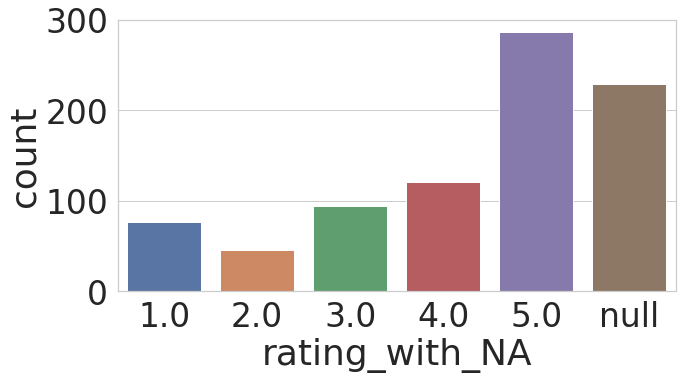

In [ ]:
plt.figure(figsize=(10,5))
data["rating_with_NA"] = data['product_rating'].fillna('null')
sns.countplot(data['rating_with_NA'])

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


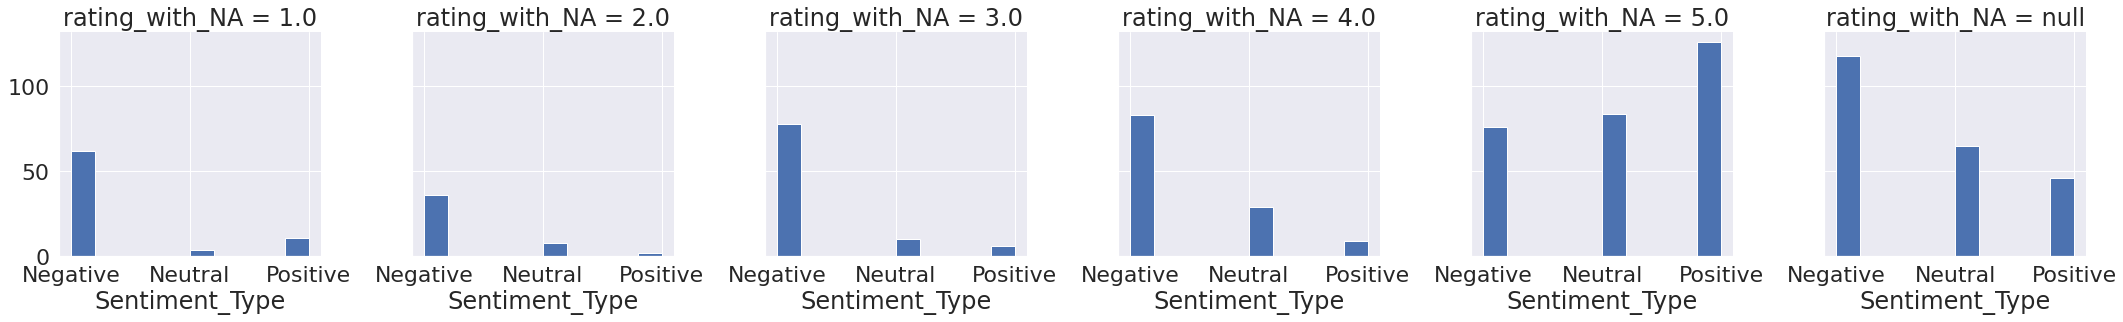

In [ ]:
sns.set(font_scale=2.0)

g = sns.FacetGrid(data,col='rating_with_NA',size=5, margin_titles=True)
g.map(plt.hist,'Sentiment_Type')

In [ ]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [ ]:
data[['product_feedback','product_rating','Sentiment_Type']].sample(10, random_state = 100)

,product_feedback,product_rating,Sentiment_Type
824,The student name was Gulnas and not Aditya.,NaN,Neutral
489,No Technical issue from my side.\nThe student had some issues with internet connectivity. He was very happy to be in the class and was very excited. Please call the parents as they are interest to join.,5.0,Positive
509,"Pari was very much interested but due to network issues, she had audio problems - most of the time I could not hear her and some times she could nit hear me. She wants to repeat the demo.",5.0,Negative
134,"Facing screen issues again, especially at the last slide.",3.0,Negative
376,"Both the kids were good, Darshan had a lot of background noise.",5.0,Positive
458,"Manya joined the class on time , but i was not able to hear her , she got the class rescheduled . Khwaish joined the class 30mins late , we talked a little , advised him to reschedule .",5.0,Negative
574,Sumit and Vishal had very high engagement in spite of technical problems as they could not do all the external activities.,5.0,Negative
731,Nikitha joined using a tab and had very poor connectivity.,NaN,Negative
641,Ashlesha parents were not there .I explained Ashlesha in detail about Lido way of learning,NaN,Neutral
384,"call parents , his mom wants to know the fee structure.\nThanking you",5.0,Positive


### Sentiment Per Teacher

In [ ]:
avg_feedback_length_per_teacher = data.groupby("teacher_name").agg({"number_of_words" : np.mean})
avg_feedback_length_per_teacher

,number_of_words
teacher_name,
Aanchal Chopra,7.000000
Aayushi Kumari,10.000000
Abhimanyu Chaudhary,36.846154
Abhishek Sharma,11.000000
Abhishikta,11.333333
...,...
Vignesh M,21.333333
Vivek Gaurav,16.000000
Vivek Surve,13.000000


In [ ]:
avg_rating_per_teacher = data.groupby("teacher_name").agg({"product_rating" : np.mean})
avg_rating_per_teacher

,product_rating
teacher_name,
Aanchal Chopra,2.000000
Aayushi Kumari,2.500000
Abhimanyu Chaudhary,3.250000
Abhishek Sharma,1.000000
Abhishikta,1.000000
...,...
Vignesh M,3.166667
Vivek Gaurav,NaN
Vivek Surve,5.000000


In [ ]:
count_feedback = data.groupby("teacher_name").agg({'teacher_name':'count'})
count_feedback

,teacher_name
teacher_name,
Aanchal Chopra,1
Aayushi Kumari,3
Abhimanyu Chaudhary,13
Abhishek Sharma,2
Abhishikta,3
...,...
Vignesh M,6
Vivek Gaurav,1
Vivek Surve,3


In [ ]:
avg_emotion_per_teacher = data.groupby("teacher_name").agg({"sentiment" : np.mean})
avg_emotion_per_teacher

,sentiment
teacher_name,
Aanchal Chopra,-0.859555
Aayushi Kumari,-0.505406
Abhimanyu Chaudhary,-0.571796
Abhishek Sharma,-0.777345
Abhishikta,-0.178097
...,...
Vignesh M,-0.741586
Vivek Gaurav,0.376441
Vivek Surve,-0.188260


In [ ]:
teacher_df = pd.concat([avg_feedback_length_per_teacher, avg_rating_per_teacher, count_feedback, avg_emotion_per_teacher], axis=1)
sorted_teacher_df = teacher_df.sort_values(by="sentiment", ascending=False, na_position='last')
sorted_teacher_df

,number_of_words,product_rating,teacher_name,sentiment
teacher_name,,,,
Ankita pandey,10.923077,5.000000,13,0.782206
Namira Kadri,16.000000,5.000000,1,0.496903
Himanshu Manral,17.695652,5.000000,23,0.488506
Bonuga Mounya,18.000000,NaN,2,0.436571
Navneet Khubber,13.000000,5.000000,1,0.385663
...,...,...,...,...
Mohanraj R,12.000000,1.000000,2,-0.907782
Anas khan,12.000000,3.000000,1,-0.919206
Soumodeep Bhowmick,21.000000,NaN,1,-0.922152


**NOTE: Every Column is AVG Except teacher name its is `Count of Feedback`**

In [ ]:
### Download CSV for this DataFrame if required 


sorted_teacher_df.to_csv('teacher_data.csv') 
files.download('teacher_data.csv')

### Upload Data here

In [ ]:
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['updated_reviews.csv']))

Saving updated_reviews.csv to updated_reviews (1).csv


In [ ]:
data.head()

,Unnamed: 0,product_feedback,product_rating,teacher_id,teacher_name,teacher_rmn,vc_id,start_time,count_students,student_ids,student_names,student_rmns,rating_with_NA,reviews_length,number_of_words,cleaned_feedback,sentence,sentiment,Sentiment_Type
0,0,1. Most of the times the screen share option c...,1.0,28e89e38-fb05-4082-84aa-1f9443d43383,Lalit Upadhyay,9004097187,4fc2f040-aaef-4e2e-9c9d-101d3f5b7bc6,2020-09-05T16:00:00+05:30,3,"{76dd93d7-0336-4e49-b3bd-1fe92e6ca289,9af94c6c...","{Sachi,SAKSHAM,Tanesh}","{8018256529,8126414600,9027917598}",1.0,381,61,1 most of the time the screen share option cre...,1 most of the time the screen share option cre...,-0.882468,Negative
1,1,aaditya tried everything but his mic did not w...,1.0,f09c9aef-c221-4858-b0b6-cfee341fa761,Vasundhara Guleria,8264861796,0c964071-5fc0-42a0-a6a9-d42cc59e0f61,2020-09-12T13:00:00+05:30,4,"{2543fa86-1748-4b31-a8ca-7040943f791e,5b471717...","{ADITYA,AWADH,KAVERI,""Zara Khan ""}","{8387977000,9399073915,9587358465,9878138080}",1.0,128,23,aaditya try everything but his mic do not work...,aaditya try everything but his mic do not work...,-0.810417,Negative
2,2,"Anurag is having least intrest in this class, ...",1.0,d73677b0-7f22-4028-8a76-1dcec5347ab4,Nirmal Kumar Singh,8982753944,cfc68463-3c65-4a9f-80fa-d0ad52ba136f,2020-09-09T18:00:00+05:30,3,"{5200eb31-49ec-4a2c-9170-4660d25e931b,523bf469...","{""Anurag "",""Ayan Ansari"",Karthik}","{7275767144,8979812304,9133095437}",1.0,175,34,aura be have least interest in this class but ...,aura be have least interest in this class but ...,-0.541781,Negative
3,3,At end of the class. I and aliza both face som...,1.0,55aebf7f-6a90-491e-931d-3e0e0666dca8,Riya Makhani,6353905546,61c64a19-4c80-4fd3-a67f-58e69037c1fb,2020-09-02T16:00:00+05:30,1,{5407c90c-ab9c-4228-b2a0-071d8e3d496f},{ALIZAA},{7417134771},1.0,179,36,at end of the class i and liza both face some ...,at end of the class i and liza both face some ...,0.996917,Positive
4,4,"at first, my mic was not working so I asked to...",1.0,92d28ccc-442f-4b22-8b2b-59d4c08471de,Shafiq Ur Rehman,9999094192,9c54d54c-c94c-4b5a-a2d6-f8467972325b,2020-09-02T18:00:00+05:30,1,{6ec42414-9846-4be8-91d9-6390985169a1},{SANU},{7906733631},1.0,188,37,at first my mic be not work so i ask to reload...,at first my mic be not work so i ask to reload...,-0.969891,Negative


In [ ]:
neg_df = data[data['Sentiment_Type']=='Negative']
neg_df.shape

(503, 19)

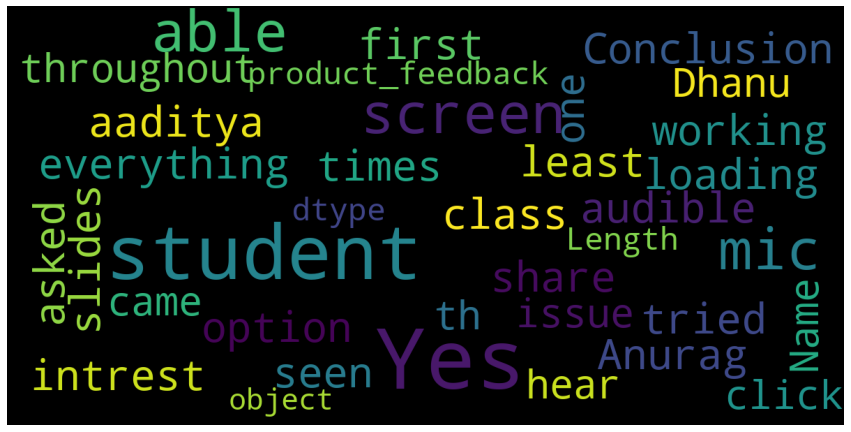

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


show_wordcloud(neg_df['product_feedback'])

## Topic Modelling

The shape of the tfidf is (503, 75), meaning that there are 503 cleaned_feedback and 75 tokens made through the filtering process.
Best Model's Params:  {'learning_decay': 0.5, 'learning_method': 'online', 'n_components': 5, 'random_state': 0}
Model Log Likelihood Score:  -1318.3257459301074
Model Perplexity:  134.47561197070513


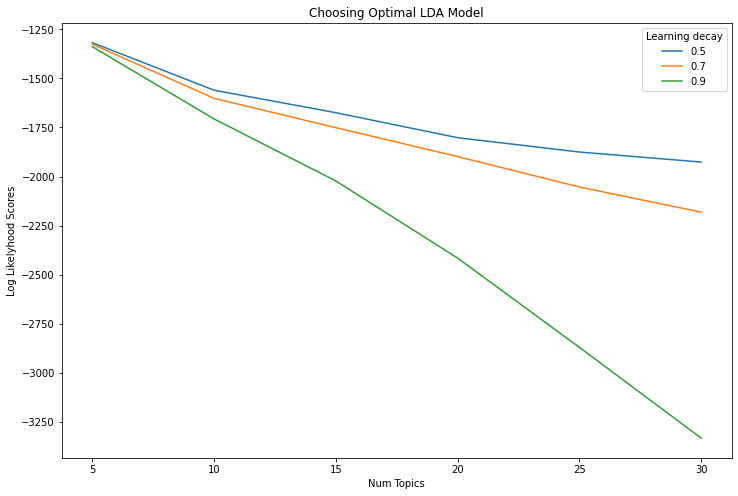

In [ ]:
#def optimal_lda_model(df_review, review_colname):
df_review, review_colname = neg_df, 'cleaned_feedback'
'''
INPUTS:
    df_review - dataframe that contains the reviews
    review_colname: name of column that contains reviews
    
OUTPUTS:
lda_tfidf - Latent Dirichlet Allocation (LDA) model
dtm_tfidf - document-term matrix in the tfidf format
tfidf_vectorizer - word frequency in the reviews
A graph comparing LDA Model Performance Scores with different params
'''
docs_raw = df_review[review_colname].tolist()
#************   Step 1: Convert to document-term matrix   ************#

#Tansform text to vector form using the vectorizer object 
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                                max_df = 0.9,                        # discard words that appear in > 90% of the reviews
                                min_df = 10)                         # discard words that appear in < 10 reviews    

#aply transformation
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())

#cnvert to document-term matrix
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)  

print("The shape of the tfidf is {}, meaning that there are {} {} and {} tokens made through the filtering process.".\
          format(dtm_tfidf.shape,dtm_tfidf.shape[0], review_colname, dtm_tfidf.shape[1]))

#*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

# efine Search Param
search_params = {'n_components': [5, 10, 15, 20, 25, 30], 
                 'learning_decay': [.5, .7, .9],
                 'learning_method':['online'],
                 'random_state': [0]}

# nit the Model
lda = LatentDirichletAllocation()

# nit Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(dtm_tfidf)
#*****  Step 3: Output the optimal lda model and its parameters  *****#
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score: Higher the better
print("Model Log Likelihood Score: ", model.best_score_)
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))


#*********   Step 4: Compare LDA Model Performance Scores   ***********#

#Gt Log Likelyhoods from Grid Search Output
gscore=model.fit(dtm_tfidf).cv_results_
n_topics = [5, 10, 15, 20, 25, 30]

log_likelyhoods_5 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.5]
log_likelyhoods_7 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.7]
log_likelyhoods_9 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.9]

   # Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()
    
    #return best_lda_model, dtm_tfidf, tfidf_vectorizer
    
#best_lda_model, dtm_tfidf, tfidf_vectorizer = optimal_lda_model(neg_df, 'cleaned_feedback')

In [ ]:
def display_topics(model, feature_names, n_top_words):
    '''
    INPUTS:
        model - the model we created
        feature_names - tells us what word each column in the matric represents
        n_top_words - number of top words to display
    OUTPUTS:
        a dataframe that contains the topics we created and the weights of each token
    '''
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        
    return pd.DataFrame(topic_dict)


display_topics(best_lda_model, tfidf_vectorizer.get_feature_names(), n_top_words = 20) 

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,class,30.5,issue,29.5,internet,17.5,screen,26.3,able,32.0
1,join,20.8,technical,21.2,poor,6.9,share,16.3,student,30.5
2,offline,19.3,drop,15.8,connection,6.7,load,12.3,slide,25.6
3,time,16.9,voice,15.5,slow,5.7,student,11.5,hear,25.0
4,parent,15.8,face,15.1,connectivity,4.0,able,8.8,network,18.2
5,student,15.3,student,15.0,student,2.9,slide,8.8,unable,15.8
6,able,13.1,tech,12.6,work,2.8,yes,6.7,issue,14.1
7,try,12.9,lot,12.1,disconnect,2.0,game,6.4,face,13.1
8,start,11.8,class,12.0,use,1.5,work,6.3,problem,10.0
9,dint,11.2,hear,11.8,class,1.4,leave,5.2,class,9.6


In [ ]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.014534  0.030495       1        1  31.455939
4     -0.181022  0.033416       2        1  22.116635
1     -0.009492  0.207985       3        1  21.751155
3     -0.064033 -0.245047       4        1  15.090509
2      0.269081 -0.026849       5        1   9.585762, topic_info=        Term       Freq      Total Category  logprob  loglift
26  internet  27.000000  27.000000  Default  30.0000  30.0000
53    screen  29.000000  29.000000  Default  29.0000  29.0000
55     share  18.000000  18.000000  Default  28.0000  28.0000
0       able  49.000000  49.000000  Default  27.0000  27.0000
27     issue  41.000000  41.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
28      join   0.315875  22.799139   Topic5  -5.7778  -1.9342
27     issue   0.314493  41.951299   Topic5  -5.7822  -2.5484
56     slide   0.314277  38.982840   Topic5  -5.7829  -2.4757
20       end   0.313089  14.818722   Topic5  -5.7866  -1.5123
24      hear   0.312562  43.696010   Topic5  -5.7883  -2.5953

[217 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.220336      able
0         2  0.580886      able
0         4  0.180275      able
1         1  0.300485  activity
1         2  0.701132  activity
...     ...       ...       ...
73        3  0.048568      work
73        4  0.339978      work
73        5  0.194273      work
74        1  0.195502       yes
74        4  0.684256       yes

[146 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 4, 3])

In [ ]:
topic_dict = {0 : 'Miscellaneous issues', 
              1 : 'Slides/Network/Delay issues', 
              2 : 'Drop/Voice/Audio issues', 
              3 : 'Screen Sharing/Loading issues', 
              4 : 'Internet Connectivity issues',}

In [ ]:
categories_probability = best_lda_model.transform(dtm_tfidf)
categories_probability, categories_probability.shape

(array([[0.04877429, 0.41293365, 0.04499123, 0.44686212, 0.04643871],
        [0.64551783, 0.05942008, 0.05930914, 0.17596235, 0.05979061],
        [0.71897405, 0.06983025, 0.06924403, 0.06937908, 0.0725726 ],
        ...,
        [0.38230872, 0.39413159, 0.07420714, 0.07457017, 0.07478239],
        [0.56173092, 0.05686072, 0.05636666, 0.06144738, 0.26359431],
        [0.07117532, 0.0703796 , 0.07033067, 0.36098093, 0.42713349]]),
 (503, 5))

In [ ]:
mykeys = [np.argmax(p) for p in categories_probability] 
print(mykeys)

[3, 0, 0, 0, 3, 4, 0, 0, 4, 4, 4, 1, 0, 1, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 1, 1, 4, 4, 4, 0, 4, 4, 3, 0, 3, 0, 0, 0, 4, 0, 0, 4, 0, 3, 3, 4, 3, 0, 1, 0, 3, 1, 4, 4, 0, 0, 0, 3, 4, 4, 0, 3, 0, 4, 0, 3, 0, 3, 0, 4, 1, 0, 1, 0, 4, 2, 1, 1, 0, 0, 0, 0, 0, 3, 0, 3, 4, 4, 0, 3, 0, 4, 0, 0, 4, 3, 1, 0, 4, 3, 1, 0, 1, 1, 4, 0, 0, 4, 4, 1, 3, 0, 1, 4, 1, 0, 4, 4, 0, 0, 2, 4, 4, 4, 2, 4, 3, 0, 0, 2, 3, 0, 0, 4, 0, 2, 1, 4, 1, 0, 4, 3, 0, 3, 0, 4, 0, 4, 4, 1, 2, 2, 0, 0, 3, 1, 3, 3, 0, 4, 4, 3, 4, 0, 0, 3, 4, 1, 0, 4, 3, 4, 1, 0, 1, 0, 0, 2, 4, 4, 0, 1, 4, 3, 1, 0, 3, 1, 4, 0, 4, 1, 4, 1, 0, 0, 1, 4, 4, 4, 4, 3, 0, 4, 0, 0, 3, 2, 4, 0, 0, 4, 0, 0, 4, 3, 0, 3, 4, 1, 0, 4, 0, 0, 3, 3, 3, 3, 0, 4, 0, 4, 4, 4, 3, 4, 4, 4, 0, 1, 1, 4, 4, 4, 2, 0, 1, 0, 4, 0, 4, 0, 1, 0, 4, 4, 1, 1, 1, 0, 4, 0, 1, 2, 1, 4, 4, 1, 0, 0, 1, 3, 0, 4, 0, 1, 0, 1, 1, 0, 2, 0, 0, 1, 3, 1, 0, 2, 4, 0, 0, 0, 1, 1, 0, 1, 4, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 1, 3, 1, 1, 1, 1, 1, 1, 0, 4, 3, 1, 1, 2, 1, 1, 4, 2, 

In [ ]:
neg_df['Categories'] = [topic_dict[x] for x in mykeys]
neg_df.head()

,Unnamed: 0,product_feedback,product_rating,teacher_id,teacher_name,teacher_rmn,vc_id,start_time,count_students,student_ids,student_names,student_rmns,rating_with_NA,reviews_length,number_of_words,cleaned_feedback,sentence,sentiment,Sentiment_Type,Categories
0,0,"1. Most of the times the screen share option creates technical issues and ruins the class. (Even when network is good).\n2. Student (Saksham, Grade 7, Maths) had some issue after I tried sharing screen, he turned offline and was not able to re-login.\n3. Game website on slide number 10 - (https://in.mathgames.com/skill/7.8-multiply-fractions) always takes a lot of time in opening.",1.0,28e89e38-fb05-4082-84aa-1f9443d43383,Lalit Upadhyay,9004097187,4fc2f040-aaef-4e2e-9c9d-101d3f5b7bc6,2020-09-05T16:00:00+05:30,3,"{76dd93d7-0336-4e49-b3bd-1fe92e6ca289,9af94c6c-cba4-4ac2-aef7-9dadcad97547,ec4ec786-a17c-4a59-a1dd-e92b04bc88ce}","{Sachi,SAKSHAM,Tanesh}","{8018256529,8126414600,9027917598}",1.0,381,61,1 most of the time the screen share option create technical issue and ruin the class even when network be good 2 student wakeham grade 7 math have some issue after i try share screen he turn offline and be not able to religion 3 game webster on slide number 10 always take a lot of time in open,1 most of the time the screen share option create technical issue and ruin the class even when network be good 2 student wakeham grade 7 math have some issue after i try share screen he turn offline and be not able to religion 3 game webster on slide number 10 always take a lot of time in open,-0.882468,Negative,Screen Sharing/Loading issues
1,1,"aaditya tried everything but his mic did not work, kaveri was not near the screen but could hear her talking in the background",1.0,f09c9aef-c221-4858-b0b6-cfee341fa761,Vasundhara Guleria,8264861796,0c964071-5fc0-42a0-a6a9-d42cc59e0f61,2020-09-12T13:00:00+05:30,4,"{2543fa86-1748-4b31-a8ca-7040943f791e,5b471717-9223-4709-adec-32f6f983ca39,b4b390d5-47b8-4c6d-9bc1-de6e8bf418e7,dac7aeb6-9190-4828-a1ee-db81429a804d}","{ADITYA,AWADH,KAVERI,""Zara Khan ""}","{8387977000,9399073915,9587358465,9878138080}",1.0,128,23,aaditya try everything but his mic do not work tavern be not near the screen but could hear her talk in the background,aaditya try everything but his mic do not work tavern be not near the screen but could hear her talk in the background,-0.810417,Negative,Miscellaneous issues
2,2,"Anurag is having least intrest in this class, but he is more focus on class book problem. I solve some .\nKartik join late but great student , weak in some sort of calculation.",1.0,d73677b0-7f22-4028-8a76-1dcec5347ab4,Nirmal Kumar Singh,8982753944,cfc68463-3c65-4a9f-80fa-d0ad52ba136f,2020-09-09T18:00:00+05:30,3,"{5200eb31-49ec-4a2c-9170-4660d25e931b,523bf469-e88a-4bd7-ab94-bec8b5854d5d,689f7429-0f2e-4dd3-b659-98ef91f242ef}","{""Anurag "",""Ayan Ansari"",Karthik}","{7275767144,8979812304,9133095437}",1.0,175,34,aura be have least interest in this class but he be more focus on class book problem i solve some martin join late but great student weak in some sort of calculation,aura be have least interest in this class but he be more focus on class book problem i solve some martin join late but great student weak in some sort of calculation,-0.541781,Negative,Miscellaneous issues
4,4,"at first, my mic was not working so I asked to reload the page to my student and reloaded my page too. after that. Student's mic was not working even after reloading the page so many times",1.0,92d28ccc-442f-4b22-8b2b-59d4c08471de,Shafiq Ur Rehman,9999094192,9c54d54c-c94c-4b5a-a2d6-f8467972325b,2020-09-02T18:00:00+05:30,1,{6ec42414-9846-4be8-91d9-6390985169a1},{SANU},{7906733631},1.0,188,37,at first my mic be not work so i ask to reload the page to my student and reload my page too after that student mic be not work even after reload the page so many time,at first my mic be not work so i ask to reload the page to my student and reload my page too after that student mic be not work even a

In [ ]:
pd.set_option('display.max_colwidth', 500)

In [ ]:
neg_df[['product_feedback', 'Categories']].head(20)

,product_feedback,Categories
0,"1. Most of the times the screen share option creates technical issues and ruins the class. (Even when network is good).\n2. Student (Saksham, Grade 7, Maths) had some issue after I tried sharing screen, he turned offline and was not able to re-login.\n3. Game website on slide number 10 - (https://in.mathgames.com/skill/7.8-multiply-fractions) always takes a lot of time in opening.",Screen Sharing/Loading issues
1,"aaditya tried everything but his mic did not work, kaveri was not near the screen but could hear her talking in the background",Miscellaneous issues
2,"Anurag is having least intrest in this class, but he is more focus on class book problem. I solve some .\nKartik join late but great student , weak in some sort of calculation.",Miscellaneous issues
4,"at first, my mic was not working so I asked to reload the page to my student and reloaded my page too. after that. Student's mic was not working even after reloading the page so many times",Miscellaneous issues
6,"Conclusion slides were not loading, I had to explain everything without the slides. please fix that",Screen Sharing/Loading issues
7,could not hear from my student.,Internet Connectivity issues
8,"couldnot hear the students, students dropped due to technical issues, tried relogin and asked students to do the same but was of no use",Miscellaneous issues
9,could not use any available feature on the platform. I kept on disconnected and once i re login start class option was not working.,Miscellaneous issues
10,"earlier, slides were not moving from student's side and activity was also not working.",Internet Connectivity issues
12,I could not hear Pradyun. He had network issues. He could not hear me as well,Internet Connectivity issues


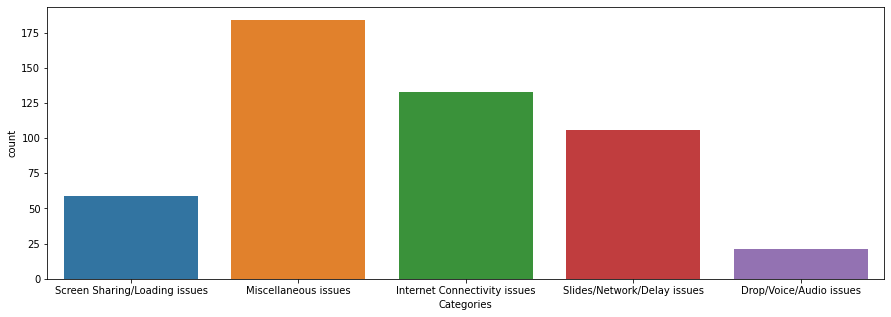

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(neg_df['Categories'])